In [33]:
# conda activate SpaceHack_MM
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.linear_model import RANSACRegressor, LinearRegression 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import sparse
import numpy as np
import pandas as pd
import libpysal as lps
from esda import Moran
import seaborn as sns
from scipy.stats import pearsonr
import squidpy as sq
from matplotlib.lines import Line2D

from spatial_compare import  SpatialCompare, spatial_detection_scores, detect_outliers
#If detect_outliers() is not working from spatial_compare, simply uncomment the function in the cell above.

In [34]:
def load_h5ad_data(file_path):
    adata = sc.read_h5ad(file_path)
    return adata


# def detect_outliers(adata1, adata2, transform_type='none', gene_name='', inlier_threshold=0.7, display_others_plot=False, display_outlier_plot=False):
#     """
#     Detect outliers in gene expression data using RANSAC regression.

#     Parameters:
#     - adata1: AnnData object for dataset 1.
#     - adata2: AnnData object for dataset 2.
#     - transform_type: Type of transformation to apply ('scale', 'log', or 'none').
#     - gene_name: Specific gene to visualize (if empty, visualizes the first inlier).
#     - inlier_threshold: Proportion of inliers required to classify a gene as an inlier. It’s a percentage of cells that got an "Inlier" label from RANSAC for a given gene based on their expression level. If your proportion_inliers >= inlier_threshold, the gene going through the loop will be labeled as an inlier. Otherwise, it'll be labeled as an outlier.
#     - display_others_plot: Boolean indicating whether to display the plot for a specific gene. Work in progress.
#     - display_outlier_plot: Boolean indicating whether to display the outlier plot.

#     Returns:
#     - Prints lists of inlier and outlier genes.
#     """
    
#     # Function to ensure dense matrix
#     def ensure_dense(matrix):
#         return matrix.toarray() if hasattr(matrix, 'toarray') else matrix

#     # Prepare inputs
#     X = ensure_dense(adata1.X)  # Convert adata1.X to dense if necessary
#     Y = ensure_dense(adata2.X)  # Convert adata2.X to dense if necessary

#     genes1 = adata1.var_names
#     genes2 = adata2.var_names

#     # Create DataFrames
#     df1 = pd.DataFrame(X, columns=genes1)
#     df2 = pd.DataFrame(Y, columns=genes2)
    
#     # Remove genes containing 'UnassignedCodeword' from both datasets
#     mask1 = ~df1.columns.str.contains('UnassignedCodeword|NegControlProbe|NegControlCodeword', case=False)
#     mask2 = ~df2.columns.str.contains('UnassignedCodeword|NegControlProbe|NegControlCodeword', case=False)

#     df1 = df1.loc[:, mask1]
#     df2 = df2.loc[:, mask2]

#     # Find common genes after filtering
#     common_genes = list(set(df1.columns).intersection(set(df2.columns)))

#     # Initialize lists to store results
#     inlier_genes = []
#     outlier_genes = []

#     # Analyze each common gene independently
#     for gene in common_genes:
#         # Extract expression levels for the current gene
#         X_gene = df1[gene].dropna().to_numpy()  # Drop NaN values if any
#         Y_gene = df2[gene].dropna().to_numpy()  # Drop NaN values if any

#         # If either dataset has no data for this gene, skip it
#         if len(X_gene) == 0 or len(Y_gene) == 0:
#             continue

#         # Apply transformations based on the transform_type parameter
#         if transform_type == 'log':
#             X_gene = np.log1p(X_gene)  # log(1 + x) handles zero values safely
#             Y_gene = np.log1p(Y_gene)
#         elif transform_type == 'scale':
#             scaler = StandardScaler()
#             X_gene = scaler.fit_transform(X_gene.reshape(-1, 1))
#             Y_gene = scaler.fit_transform(Y_gene.reshape(-1, 1))

#         # Use only the minimum length of the two arrays for fitting
#         min_length = min(len(X_gene), len(Y_gene))

#         # Fit RANSAC regressor for the current gene using only available data
#         ransac = RANSACRegressor(random_state=42)
#         ransac.fit(X_gene[:min_length].reshape(-1, 1), Y_gene[:min_length].reshape(-1, 1))

#         # Extract inliers and outliers for this gene
#         inlier_mask = ransac.inlier_mask_

#         # Calculate proportion of inliers
#         proportion_inliers = np.sum(inlier_mask) / min_length
        
#         # Check if proportion of inliers meets threshold
#         if proportion_inliers >= inlier_threshold:
#             inlier_genes.append(gene)
#         else:
#             outlier_genes.append(gene)

#     # Select a specific gene to visualize (if provided)
#     selected_gene = gene_name if gene_name else (inlier_genes[0] if inlier_genes else None)

#     if selected_gene and display_others_plot:
#         X_selected = df1[selected_gene].dropna().to_numpy().reshape(-1, 1)
#         Y_selected = df2[selected_gene].dropna().to_numpy().reshape(-1, 1)

#         # Apply transformations for visualization based on transform_type
#         if transform_type == 'log':
#             X_selected = np.log1p(X_selected)
#             Y_selected = np.log1p(Y_selected)
#         elif transform_type == 'scale':
#             scaler = StandardScaler()
#             X_selected = scaler.fit_transform(X_selected)
#             Y_selected = scaler.fit_transform(Y_selected)

#         # Align lengths for visualization
#         min_length = min(len(X_selected), len(Y_selected))

#         ransac.fit(X_selected[:min_length], Y_selected[:min_length])
#         inlier_mask_visual = ransac.inlier_mask_

#         plt.figure(figsize=(8, 5))
#         plt.scatter(X_selected[inlier_mask_visual], Y_selected[inlier_mask_visual], color='blue', label='Inliers')
#         plt.scatter(X_selected[~inlier_mask_visual], Y_selected[~inlier_mask_visual], color='red', label='Outliers')

#         # Plotting the RANSAC fit line based on transformed data
#         plt.plot(X_selected, ransac.predict(X_selected), color='green', label='RANSAC fit')

#         plt.xlabel(f'Gene Expression (Dataset 1) - {selected_gene}')
#         plt.ylabel(f'Gene Expression (Dataset 2) - {selected_gene}')
#         plt.title(f'RANSAC Outlier Detection for {selected_gene}')
#         plt.legend()
#         plt.show()
#     else:
#         print("No inliers found to visualize or plotting is disabled.")

#         # Print outlier and inlier genes
#         print("Inlier Genes:", inlier_genes)
#         print("Inlier nGenes:", len(inlier_genes))
#         print("Outlier Genes:", outlier_genes)
#         print("Outlier nGenes:", len(outlier_genes))

#     if display_outlier_plot:
    
#         # Step 1: Extract common genes
#         common_genes = adata1.var_names.intersection(adata2.var_names)

#         # Step 2: Sort common genes
#         sorted_common_genes = sorted(common_genes)

#         # Step 3: Reorder AnnData objects based on sorted common genes
#         adata1_sorted = adata1[:, sorted_common_genes]
#         adata2_sorted = adata2[:, sorted_common_genes]

#         # Step 4: Calculate average expression for sorted common genes
#         avg_expr_adata1 = np.asarray(adata1_sorted.X.mean(axis=0)).flatten()
#         avg_expr_adata2 = np.asarray(adata2_sorted.X.mean(axis=0)).flatten()

#         # Check shapes
#         print("Shape of avg_expr_adata1:", avg_expr_adata1.shape)
#         print("Shape of avg_expr_adata2:", avg_expr_adata2.shape)

#         # Step 5: Log-transform the average expression values
#         log_avg_expr_adata1 = np.log1p(avg_expr_adata1)  # log(1 + x)
#         log_avg_expr_adata2 = np.log1p(avg_expr_adata2)

#         # Step 6: Create a DataFrame with ordered data
#         data = pd.DataFrame({
#             'gene': sorted_common_genes,
#             'adata1_avg': log_avg_expr_adata1,
#             'adata2_avg': log_avg_expr_adata2
#         })

#         # Step 7: Create a new column for color based on outlier genes
#         data['color'] = np.where(data['gene'].isin(outlier_genes), 'red', 'blue')

#         # Step 8: Create scatter plot with colors for outliers and inliers
#         plt.figure(figsize=(8, 6))
        
#         sns.scatterplot(data=data, x='adata1_avg', y='adata2_avg', hue='color', palette={'red': 'red', 'blue': 'blue'}, legend=False)

#         # Step 9: Annotate outlier genes on the plot
#         for index, row in data.iterrows():
#             if row['color'] == 'red':
#                 plt.text(row['adata1_avg'], row['adata2_avg'], row['gene'], fontsize=9, ha='right', va='bottom')

#         # Step 10: Calculate and display correlation coefficient on log-transformed data
#         correlation = np.corrcoef(data['adata1_avg'], data['adata2_avg'])[0, 1]
#         plt.title(f'Scatter Plot of Log-Transformed Average Gene Expression\nCorrelation: {correlation:.2f}')
#         plt.xlabel('Log-Transformed Average Expression in adata1')
#         plt.ylabel('Log-Transformed Average Expression in adata2')
#         plt.grid(True)

#         # Custom legend handles to match colors
#         legend_elements = [
#             Line2D([0], [0], marker='o', color='w', label='Inlier Genes', markerfacecolor='blue', markersize=10),
#             Line2D([0], [0], marker='o', color='w', label='Outlier Genes', markerfacecolor='red', markersize=10)
#         ]

#         plt.legend(handles=legend_elements, title='Gene Type')
#         plt.show()
    
#     return inlier_genes, outlier_genes





def calculate_moran_scores(gene_list, adata, distance_threshold, x_coord_col='x_centroid', y_coord_col='y_centroid'):
    """
    Calculate Moran's I scores for a list of genes in a given AnnData object.

    Parameters:
    - gene_list: List of genes to analyze.
    - adata: AnnData object containing the expression data and spatial coordinates.
    - distance_threshold: Distance threshold for creating spatial weights.
    - x_coord_col: Name of the column in adata.obs for x coordinates.
    - y_coord_col: Name of the column in adata.obs for y coordinates.

    Returns:
    - DataFrame containing Moran's I scores and p-values for each gene.
    """
    
    # Step 1: Filter the AnnData object for the genes of interest
    filtered_genes = [gene for gene in gene_list if gene in adata.var_names]

    # Extract the expression data for the filtered genes
    gene_expression = adata[:, filtered_genes].X  # This will give a sparse matrix

    # Convert sparse matrix to dense if necessary
    if hasattr(gene_expression, 'toarray'):
        gene_expression = gene_expression.toarray()  # Convert to dense if it's sparse

    # Step 2: Extract coordinates from adata.obs using specified columns
    coords = adata.obs[[x_coord_col, y_coord_col]].values

    # Step 3: Create a spatial weights matrix (distance-based)
    w = lps.weights.DistanceBand(coords, threshold=distance_threshold)

    # Step 4: Calculate Moran's I for each gene of interest
    results = []
    
    for i, gene in enumerate(filtered_genes):
        moran = Moran(gene_expression[:, i], w)
        results.append({
            'Gene': gene,
            'Moran_I': moran.I,
            'p_value': moran.p_sim
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df



In [35]:
## Load data 

## Touchstone project data
file_path_1 = '/mnt/scratch1/maycon/SpaceHack/spatial_compare/data/UOA_CR_FFPE_BR_1_SYD_C_R1_adata1.h5ad'
file_path_2 = '/mnt/scratch1/maycon/SpaceHack/spatial_compare/data/UOA_XR_FFPE_BR_1_SYD_C_R1_adata2.h5ad'
adata1 = load_h5ad_data(file_path_1) # breast CosMx (downsized data)
adata2 = load_h5ad_data(file_path_2) # breast Xenium (downsized data)



No inliers found to visualize or plotting is disabled.
Inlier Genes: ['CCR7', 'ITGAX', 'VWF', 'IL7R', 'CD8A', 'C1QA', 'KRT7', 'FOXP3', 'MKI67', 'NCAM1', 'CX3CR1', 'S100A8', 'PRF1', 'PTGDS', 'MS4A1', 'PGR', 'CPA3', 'KRT8', 'MMP12', 'CD68', 'C1QC', 'BASP1', 'CCL8', 'DPT', 'PDCD1', 'CD14', 'KDR', 'CD3G', 'CD163', 'NDUFA4L2', 'NKG7', 'AIF1', 'CD19', 'ITGAM', 'CTSG', 'PECAM1', 'EGFR', 'CXCL5', 'PPARG', 'CD86', 'CD9', 'LTB', 'FASN', 'IGF1', 'ACTG2', 'ADGRE5', 'IL2RG', 'HAVCR2', 'CD79A', 'SQLE', 'KRT14', 'AQP3', 'KLRF1', 'PIGR', 'CD69', 'CENPF', 'FCER1G', 'GZMA', 'ESR1', 'APOC1', 'GNLY', 'CEACAM6', 'AR', 'MMP1', 'TACSTD2', 'SERPINA3', 'CLEC14A', 'MRC1', 'LAG3', 'RAMP2', 'ANGPT2', 'KRT23', 'TCF7', 'CD93', 'KLRB1', 'MZB1', 'CD27', 'CD80', 'TNFRSF17', 'GATA3', 'S100A4', 'DUSP5', 'GPR183', 'KIT', 'PDCD1LG2', 'SELL', 'IL3RA', 'PDGFRA', 'CD83', 'TIGIT', 'CD3E', 'CD4', 'CXCR4', 'IL2RA', 'EPCAM', 'TOP2A', 'TCL1A', 'CCL5', 'CXCL16', 'CDH1', 'SNAI1', 'GZMK', 'CTLA4', 'ADIPOQ', 'KRT5', 'CD274', 'CAV1', 

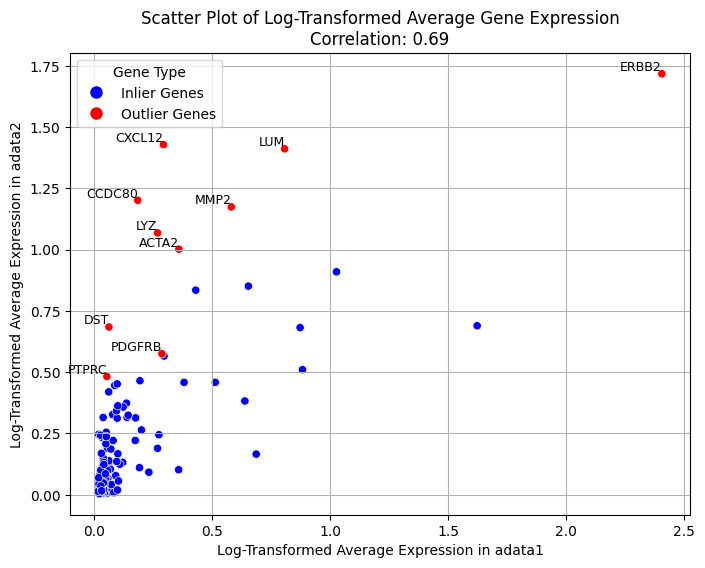

In [36]:
## Detect Outlier Genes 
inlier_genes, outlier_genes = detect_outliers(adata1, adata2, transform_type='none', gene_name='', inlier_threshold=0.7, display_others_plot=False, display_outlier_plot=True)



In [37]:
## Run calculate_moran_scores - inlier_genes
moran_results_1_fIn = calculate_moran_scores(inlier_genes, adata1, 100, x_coord_col='CenterX_global_px', y_coord_col='CenterX_global_px')
print(moran_results_1_fIn)

moran_results_2_fIn = calculate_moran_scores(inlier_genes, adata2, 100, x_coord_col='x_centroid', y_coord_col='y_centroid')
print(moran_results_2_fIn)

      Gene   Moran_I  p_value
0     CCR7 -0.000242    0.500
1    ITGAX  0.000792    0.323
2      VWF  0.003432    0.063
3     IL7R  0.001454    0.211
4     CD8A  0.004243    0.030
..     ...       ...      ...
105  CD274  0.001459    0.226
106   CAV1  0.002651    0.115
107  MYH11  0.003631    0.054
108  DUSP2  0.002808    0.103
109  CCND1  0.026340    0.001

[110 rows x 3 columns]


/mnt/scratch1/miniconda3/envs/SpaceHack_MM/lib/python3.11/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 6.
  w = W(neighbors, weights, ids, **kwargs)
/mnt/scratch1/miniconda3/envs/SpaceHack_MM/lib/python3.11/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 6.
  W.__init__(


('WARNING: ', 6, ' is an island (no neighbors)')
      Gene   Moran_I  p_value
0     CCR7  0.017073    0.002
1    ITGAX  0.042209    0.001
2      VWF  0.081410    0.001
3     IL7R  0.118944    0.001
4     CD8A  0.036440    0.001
..     ...       ...      ...
105  CD274  0.015878    0.002
106   CAV1  0.063528    0.001
107  MYH11  0.131886    0.001
108  DUSP2  0.028345    0.001
109  CCND1  0.153887    0.001

[110 rows x 3 columns]


In [20]:
# Moran's stats 
print((moran_results_1_fIn['p_value'] <= 0.05).sum())
print((moran_results_1_fIn['p_value'] > 0.05).sum())

print((moran_results_2_fIn['p_value'] <= 0.05).sum())
print((moran_results_2_fIn['p_value'] > 0.05).sum())

# Filter results by statistical sig
moran_results_1_fIn = pd.DataFrame(moran_results_1_fIn)
filtered_res_1_fIn = moran_results_1_fIn[moran_results_1_fIn['p_value'] <= 0.05]

moran_results_2_fIn = pd.DataFrame(moran_results_2_fIn)
filtered_res_2_fIn = moran_results_2_fIn[moran_results_2_fIn['p_value'] <= 0.05]

46
59
94
11


In [8]:
## Run calculate_moran_scores - outier_genes
moran_results_1_fOut = calculate_moran_scores(outlier_genes, adata1, 100, x_coord_col='CenterX_global_px', y_coord_col='CenterX_global_px')
print(moran_results_1_fOut)

moran_results_2_fOut = calculate_moran_scores(outlier_genes, adata2, 100, x_coord_col='x_centroid', y_coord_col='y_centroid')
print(moran_results_2_fOut)

       Gene   Moran_I  p_value
0       DST  0.004361    0.040
1   TACSTD2  0.037557    0.001
2     ERBB2  0.048934    0.001
3     GATA3  0.028035    0.001
4       LUM  0.035582    0.001
5       LYZ  0.005770    0.016
6     CCND1  0.026340    0.001
7     PTPRC  0.000380    0.379
8      KRT8  0.044091    0.001
9      MMP2  0.022994    0.001
10    BASP1  0.008584    0.002
11   CXCL12  0.024871    0.001
12   FCER1G  0.004530    0.029
13      CD4  0.002465    0.105
14   PDGFRB  0.012646    0.001


/mnt/scratch1/miniconda3/envs/SpaceHack_MM/lib/python3.11/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 6.
  w = W(neighbors, weights, ids, **kwargs)
/mnt/scratch1/miniconda3/envs/SpaceHack_MM/lib/python3.11/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 6.
  W.__init__(


('WARNING: ', 6, ' is an island (no neighbors)')
       Gene   Moran_I  p_value
0       DST  0.175399    0.001
1   TACSTD2  0.206515    0.001
2     ERBB2  0.310598    0.001
3     GATA3  0.230100    0.001
4       LUM  0.165535    0.001
5       LYZ  0.185562    0.001
6     CCND1  0.153887    0.001
7     PTPRC  0.135836    0.001
8      KRT8  0.267421    0.001
9      MMP2  0.151345    0.001
10    BASP1  0.078890    0.001
11   CXCL12  0.181896    0.001
12   FCER1G  0.059119    0.001
13      CD4  0.069058    0.001
14   PDGFRB  0.075063    0.001


In [21]:
## Check the statistics for moran's test
print((moran_results_1_fOut['p_value'] <= 0.05).sum())
print((moran_results_1_fOut['p_value'] > 0.05).sum())

print((moran_results_2_fOut['p_value'] <= 0.05).sum())
print((moran_results_2_fOut['p_value'] > 0.05).sum())

# Filter results by statistical sig
moran_results_1_fOut = pd.DataFrame(moran_results_1_fOut)
filtered_res_1_fOut = moran_results_1_fOut[moran_results_1_fOut['p_value'] <= 0.05]

moran_results_2_fOut = pd.DataFrame(moran_results_2_fOut)
filtered_res_2_fOut = moran_results_2_fOut[moran_results_2_fOut['p_value'] <= 0.05]

13
2
15
0


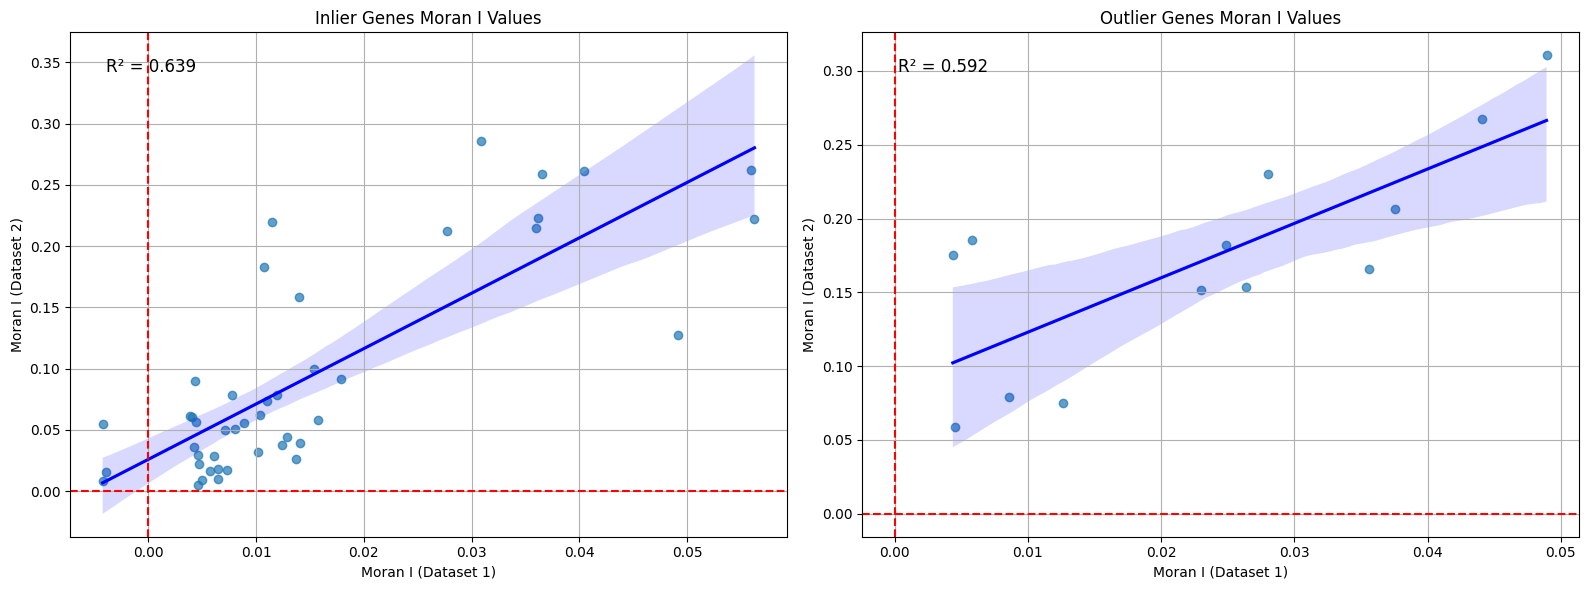

In [45]:
## Visualizing Moran's score #1
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Merging inlier and outlier data
merged_inliers = pd.merge(filtered_res_1_fIn[['Gene', 'Moran_I']], filtered_res_2_fIn[['Gene', 'Moran_I']], on='Gene', suffixes=('_Dataset1', '_Dataset2'))
merged_outliers = pd.merge(filtered_res_1_fOut[['Gene', 'Moran_I']], filtered_res_2_fOut[['Gene', 'Moran_I']], on='Gene', suffixes=('_Dataset1', '_Dataset2'))

# Calculate correlation coefficients and R-squared for inliers
correlation_coefficient_in = np.corrcoef(merged_inliers['Moran_I_Dataset1'], merged_inliers['Moran_I_Dataset2'])[0, 1]
r_squared_in = correlation_coefficient_in ** 2

# Calculate correlation coefficients and R-squared for outliers
correlation_coefficient_out = np.corrcoef(merged_outliers['Moran_I_Dataset1'], merged_outliers['Moran_I_Dataset2'])[0, 1]
r_squared_out = correlation_coefficient_out ** 2

# Set up the matplotlib figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Inlier Genes Plot
sns.regplot(data=merged_inliers, x='Moran_I_Dataset1', y='Moran_I_Dataset2', ax=axes[0], scatter_kws={'alpha':0.7}, line_kws={'color':'blue'})
axes[0].set_title('Inlier Genes Moran I Values')
axes[0].set_xlabel('Moran I (Dataset 1)')
axes[0].set_ylabel('Moran I (Dataset 2)')
axes[0].axhline(0, color='red', linestyle='--')
axes[0].axvline(0, color='red', linestyle='--')
axes[0].text(0.05, 0.95, f'R² = {r_squared_in:.3f}', transform=axes[0].transAxes, fontsize=12, verticalalignment='top')
axes[0].grid()

# Outlier Genes Plot
sns.regplot(data=merged_outliers, x='Moran_I_Dataset1', y='Moran_I_Dataset2', ax=axes[1], scatter_kws={'alpha':0.7}, line_kws={'color':'blue'})
axes[1].set_title('Outlier Genes Moran I Values')
axes[1].set_xlabel('Moran I (Dataset 1)')
axes[1].set_ylabel('Moran I (Dataset 2)')
axes[1].axhline(0, color='red', linestyle='--')
axes[1].axvline(0, color='red', linestyle='--')
axes[1].text(0.05, 0.95, f'R² = {r_squared_out:.3f}', transform=axes[1].transAxes, fontsize=12, verticalalignment='top')
axes[1].grid()

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()


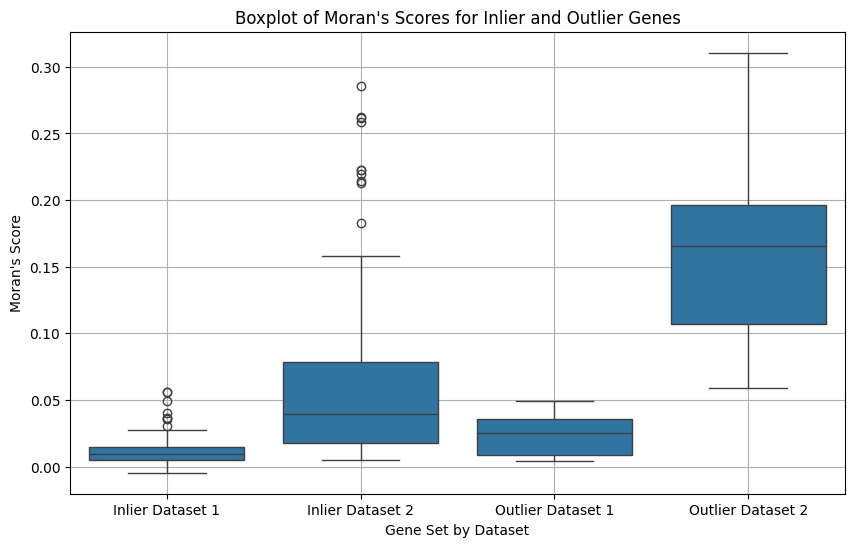

In [47]:
## Visualizing Moran's score #2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Merging inlier data
inliers_dataset_1 = filtered_res_1_fIn[['Gene', 'Moran_I']].copy()
inliers_dataset_1['Group'] = 'Inlier Dataset 1'
inliers_dataset_2 = filtered_res_2_fIn[['Gene', 'Moran_I']].copy()
inliers_dataset_2['Group'] = 'Inlier Dataset 2'

# Merging outlier data
outliers_dataset_1 = filtered_res_1_fOut[['Gene', 'Moran_I']].copy()
outliers_dataset_1['Group'] = 'Outlier Dataset 1'
outliers_dataset_2 = filtered_res_2_fOut[['Gene', 'Moran_I']].copy()
outliers_dataset_2['Group'] = 'Outlier Dataset 2'

# Concatenating all datasets into one DataFrame
all_data = pd.concat([inliers_dataset_1, inliers_dataset_2, outliers_dataset_1, outliers_dataset_2])

# Renaming columns for clarity
all_data.rename(columns={'Moran_I': 'Moran_Score'}, inplace=True)

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a boxplot
sns.boxplot(x='Group', y='Moran_Score', data=all_data)

# Add titles and labels
plt.title('Boxplot of Moran\'s Scores for Inlier and Outlier Genes')
plt.xlabel('Gene Set by Dataset')
plt.ylabel('Moran\'s Score')

# Show grid
plt.grid()

# Show the plot
plt.show()
